<a href="https://colab.research.google.com/github/g-a-b-r-e-a-l/bandgap_exploration_with_LLMs/blob/main/Iterative_experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Iterative Exploration of Molecular Bandgap with Gemini

This is a simple of concept I did as part of my application for a PhD position at the LIAC. During my interview with @philippe and @samuel, I proposed a project using an LLM to be the 'reasoning engine' in an experimentation loop. After the interview, I wanted to see how this system system would work. Here, Gemini is given a goal and iteratively predicts molecular structures (SMILES strings) and validates them using the PySCF computational chemistry package.

This is written in python and can be run in google colab.

- Starting Point: Benzene (Bandgap: 14.39 eV)
- Target: Aromatic molecule with a bandgap of ~4.5 eV
- Objective: Gemini must iteratively modify the ring structure to lower the bandgap.

### Methodology:
We tested three distinct prompting strategies, repeating each experiment 3 times:

- **One-shot prediction**: (One Shot Attempts) Single direct attempt.
- **Few-shot prediction** (Blind): Iterative attempts without explicit reasoning traces.
- **Few-shot prediction** (Reasoning): Iterative attempts requiring the model to explain its logic.

### Key Findings:
- One-shot prediction failed to perform effectively in this context.
- Few-shot predictions (both with and without reasoning) showed similar performance in reaching the target bandgap.
- **Critical Distinction**: The "Blind" model (no reasoning) occasionally suggested molecules that were computationally too expensive/large for the simulation environment. The "Reasoning" model avoided this issue, suggesting more practical candidates.

The image shows the models' convergence on the target bandgap.

### Conclusion:
While further exploration is needed to definitively quantify the improvement in predictive accuracy provided by reasoning, there is evidence that reasoning capabilities lead to more practical and feasible chemical suggestions.

With a more advance set-up, I would like to apply this to the problem of multi-step synthesis. If anyone wants to discuss this idea, I'd love to connect!





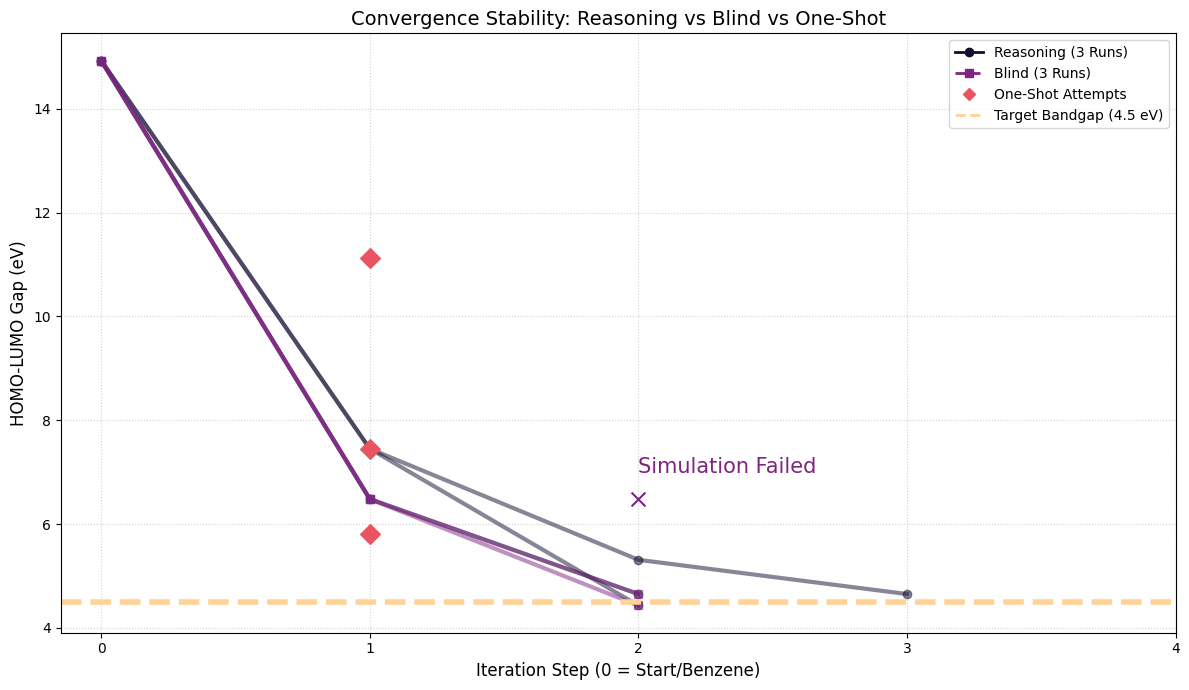

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_runs():
    """
    Visualizes multi-run data for chemical property optimization strategies.
    Plots individual trajectories for Reasoning vs Non-Reasoning agents
    and compares them against One-Shot predictions.
    """

    # --- Data Definition ---
    target_gap = 4.5

    # Structure: List of lists. Each inner list is a sequence of Gap values [Step 0, Step 1, ...]
    # "None" indicates a crash/failure at that step.

    no_reasoning_runs = [
        [14.93, 6.48, None],   # Run 1 (Crashed)
        [14.93, 6.48, 4.43],   # Run 2
        [14.93, 6.48, 4.65]    # Run 3
    ]

    reasoning_runs = [
        [14.93, 6.48, 4.65],         # Run 1
        [14.93, 7.45, 5.31, 4.65],   # Run 2 (Longer convergence)
        [14.93, 7.45, 4.43]          # Run 3
    ]

    # One-shot values are single predictions (equivalent to Step 1)
    one_shot_values = [7.45, 5.80, 11.12]

    # --- Plotting Setup ---
    fig, ax = plt.subplots(figsize=(12, 7))

    # Helper to plot a set of runs
    def plot_runs(runs, color, label_prefix, marker):
        for i, run in enumerate(runs):
            # Filter out Nones for plotting lines
            clean_run = [val for val in run if val is not None]
            x_axis = range(len(clean_run))

            # Plot line
            ax.plot(x_axis, clean_run, marker=marker, color=color, alpha=0.5, linewidth=3)

            # Mark the specific failure point if it exists
            if None in run:
                fail_idx = run.index(None)
                # Plot X at the implied next step
                ax.scatter(fail_idx, clean_run[-1], marker='x', color='#7e2482', s=100, zorder=10)
                if i == 0: # Label only once
                    ax.text(fail_idx, clean_run[-1] + 0.5, "Simulation Failed", color='#7e2482', fontsize=15)

    # 1. Plot Trajectories
    # Reasoning = Blue
    plot_runs(reasoning_runs, '#120d31', 'Reasoning', 'o')
    # No Reasoning = Grey/Black dashed
    plot_runs(no_reasoning_runs, '#7e2482', 'No Reasoning', 's')

    # 2. Plot One-Shot (Scatter at Step 1)
    # We plot these at x=1 because it corresponds to the first "proposal"
    ax.scatter([1]*len(one_shot_values), one_shot_values, color='#e95462', marker='D', s=100, label='One-Shot Predictions', zorder=5)

    # 3. Target Line
    ax.axhline(y=target_gap, color='#fed395', linestyle='--', linewidth=4, label=f'Target ({target_gap} eV)')

    # --- Formatting & Legend ---
    # Custom Legend Elements for clarity
    from matplotlib.lines import Line2D
    custom_lines = [
        Line2D([0], [0], color='#120d31', marker='o', lw=2, label='Reasoning (3 Runs)'),
        Line2D([0], [0], color='#7e2482', marker='s', lw=2, linestyle='--', label='Blind (3 Runs)'),
        Line2D([0], [0], color='#e95462', marker='D', linestyle='None', label='One-Shot Attempts'),
        Line2D([0], [0], color='#fed395', linestyle='--', lw=2, label='Target Bandgap (4.5 eV)')
    ]

    ax.legend(handles=custom_lines, loc='upper right')

    ax.set_title('Convergence Stability: Reasoning vs Blind vs One-Shot', fontsize=14)
    ax.set_ylabel('HOMO-LUMO Gap (eV)', fontsize=12)
    ax.set_xlabel('Iteration Step (0 = Start/Benzene)', fontsize=12)
    ax.set_xticks(range(5))
    ax.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Execution
if __name__ == "__main__":
    plot_all_runs()

## Set Up Environment

In [3]:
# Install RDKit and PySCF (Standard Pip packages)
!pip install -U langchain langchain-google-genai langchain-core rdkit pyscf pydantic > /dev/null

# Verify
import pyscf
from rdkit import Chem
print("System Operational. Ready for Agent Logic.")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires google-auth==2.43.0, but you have google-auth 2.45.0 which is incompatible.
gradio 5.50.0 requires pydantic<=2.12.3,>=2.0, but you have pydantic 2.12.5 which is incompatible.
System Operational. Ready for Agent Logic.


# One-Shot Prediction Using Benzene as a Reference

In [4]:
# --- CELL 2: ROBUST ONE-SHOT ATTEMPT ---
import getpass
import os
import logging
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from rdkit import Chem
from rdkit.Chem import AllChem
from pyscf import gto, scf

# Suppress PySCF logs
logging.getLogger('pyscf').setLevel(logging.ERROR)

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Paste your Google API Key: ")

# 1. Define Tool
class MoleculeProposal(BaseModel):
    proposed_smiles: str = Field(description="The SMILES string of the molecule that best matches the target gap.")

# 2. Init Model
llm = ChatGoogleGenerativeAI(model="gemini-3-pro-preview", temperature=0.7)
llm_with_tools = llm.bind_tools([MoleculeProposal], tool_choice="MoleculeProposal")

# 3. Robust Calculation Logic
def calculate_gap(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if not mol: return None

        mol = Chem.AddHs(mol)
        # Generate 3D Conformer
        if AllChem.EmbedMolecule(mol, randomSeed=42) == -1:
            AllChem.EmbedMolecule(mol, useRandomCoords=True)
        AllChem.MMFFOptimizeMolecule(mol)

        # Manual XYZ formatting (Compatible with PySCF)
        conf = mol.GetConformer()
        atoms = []
        for i, atom in enumerate(mol.GetAtoms()):
            pos = conf.GetAtomPosition(i)
            atoms.append(f"{atom.GetSymbol()} {pos.x:.4f} {pos.y:.4f} {pos.z:.4f}")
        xyz_string = "\n".join(atoms)

        # PySCF Calculation
        mol_qc = gto.M(atom=xyz_string, basis='sto-3g', verbose=0)
        mf = scf.RHF(mol_qc)
        mf.kernel()

        # Orbital Extraction
        nocc = mol_qc.nelectron // 2
        homo = mf.mo_energy[nocc - 1]
        lumo = mf.mo_energy[nocc]
        return (lumo - homo) * 27.2114
    except Exception as e:
        print(f"Debug Error: {e}")
        return None

# 4. The "One-Shot" Execution
TARGET_GAP = 4.5
start_smiles = "c1ccccc1"

print(f"🎯 Target: {TARGET_GAP} eV")
print(f"🚩 Starting Point: {start_smiles} (Benzene)")

# Establish Baseline
baseline_gap = calculate_gap(start_smiles)

if baseline_gap is not None:
    print(f"   📊 Baseline Gap: {baseline_gap:.2f} eV\n")
else:
    print("   ❌ Error: Could not calculate baseline for Benzene. Check dependencies.\n")
    # Stop execution if baseline fails
    exit()

# Single Prompt - No History
template = """
You are an expert Computational Chemist.
Task: Propose a molecule with a HOMO-LUMO gap of exactly {target} eV.
Starting Point: Benzene ({start_smiles}), which has a gap of {base_gap:.2f} eV.

Do not iterate. Use your internal chemical knowledge to propose the SINGLE BEST candidate immediately.
"""

prompt = PromptTemplate(input_variables=["target", "start_smiles", "base_gap"], template=template)
formatted_prompt = prompt.format(target=TARGET_GAP, start_smiles=start_smiles, base_gap=baseline_gap)

print("🤖 Requesting Single-Shot Prediction...")
try:
    response = llm_with_tools.invoke(formatted_prompt)

    if response.tool_calls:
        prediction = response.tool_calls[0]['args']['proposed_smiles']
        print(f"   👉 Model Predicted: {prediction}")

        # Verification
        final_gap = calculate_gap(prediction)
        if final_gap is not None:
            error = abs(TARGET_GAP - final_gap)
            print(f"   📉 Actual Gap: {final_gap:.2f} eV")
            print(f"   ❌ Error: {error:.2f} eV")

            if error < 0.2:
                print("\n✨ Lucky Guess! (Target Met)")
            else:
                print("\n⚠️ FAILED. (Optimization Loop Required)")
        else:
            print("   ❌ Calculation Failed (Invalid Geometry/SMILES)")
    else:
        print("   ⚠️ Model failed to call tool.")

except Exception as e:
    print(f"   ⚠️ System Error: {e}")

Paste your Google API Key: ··········
🎯 Target: 4.5 eV
🚩 Starting Point: c1ccccc1 (Benzene)
   📊 Baseline Gap: 14.93 eV

🤖 Requesting Single-Shot Prediction...
   👉 Model Predicted: Nc1ccc([N+](=O)[O-])cc1
   📉 Actual Gap: 12.14 eV
   ❌ Error: 7.64 eV

⚠️ FAILED. (Optimization Loop Required)


## Test Model Without Reasoning

In [5]:
# --- CELL 2: AGENT CODE ---
import getpass
import os
import logging

# Suppress PySCF internal warnings
logging.getLogger('pyscf').setLevel(logging.ERROR)

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from rdkit import Chem
from rdkit.Chem import AllChem
from pyscf import gto, scf

# 1. Setup API Key
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Paste your Google API Key: ")

# 2. Define The Tool Structure (Schema)
class MoleculeProposal(BaseModel):
    """Schema for the agent's chemical proposal."""
    reasoning_trace: str = Field(description="The chemical logic used (e.g., 'Adding electron-withdrawing group to lower LUMO').")
    proposed_smiles: str = Field(description="The valid SMILES string of the new molecule.")

# 3. Initialize Model with Function Calling
try:
    llm = ChatGoogleGenerativeAI(model="gemini-3-pro-preview", temperature=0.7)
    llm_with_tools = llm.bind_tools([MoleculeProposal], tool_choice="MoleculeProposal")
    print(f"✅ Agent Online: {llm.model_name}")
except Exception as e:
    print(f"❌ Model Init Failed: {e}")

# 4. Simulation Engine (The 'Oracle')
class ElectronicPropertyTuner:
    def __init__(self, target_gap_ev):
        self.target_gap = target_gap_ev
        self.history = []

    def smile_to_xyz(self, smiles):
        """Converts SMILES to 3D XYZ format using RDKit."""
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)
        if AllChem.EmbedMolecule(mol, randomSeed=42) == -1:
            AllChem.EmbedMolecule(mol, useRandomCoords=True)
        AllChem.MMFFOptimizeMolecule(mol)
        conf = mol.GetConformer()
        atoms = []
        for i, atom in enumerate(mol.GetAtoms()):
            pos = conf.GetAtomPosition(i)
            atoms.append(f"{atom.GetSymbol()} {pos.x:.4f} {pos.y:.4f} {pos.z:.4f}")
        return "\n".join(atoms)

    def test_molecule(self, smiles):
        """Calculates HOMO-LUMO gap using PySCF (STO-3G)."""
        try:
            xyz = self.smile_to_xyz(smiles)
            mol = gto.M(atom=xyz, basis='sto-3g', verbose=0)
            mf = scf.RHF(mol)
            mf.kernel()
            nocc = mol.nelectron // 2
            homo = mf.mo_energy[nocc - 1]
            lumo = mf.mo_energy[nocc]
            return (lumo - homo) * 27.2114 # eV
        except Exception as e:
            return None

# 5. Execution Loop
TARGET_GAP = 4.5
tuner = ElectronicPropertyTuner(TARGET_GAP)
current_smiles = "c1ccccc1" # Start with Benzene

template = """
You are a Computational Chemistry Agent using Few-Shot Learning.
Target Gap: {target} eV.

History of Experiments:
{history}

Instructions:
1. Analyze the history to understand the structure-property relationship.
2. Formulate a hypothesis (Reasoning Trace).
3. Propose a NEW, VALID SMILES string to minimize the error.
"""

prompt = PromptTemplate(input_variables=["target", "history"], template=template)

print(f"🎯 Target Gap: {TARGET_GAP} eV")
print("---------------------------------------------------")

for i in range(5):
    print(f"\n🧪 Iteration {i+1}: Testing {current_smiles}...")

    # --- A. Simulation Step ---
    gap = tuner.test_molecule(current_smiles)
    if gap is not None:
        error = abs(TARGET_GAP - gap)
        result_str = f"SMILES: {current_smiles} | Gap: {gap:.2f} eV | Error: {error:.2f}"
        tuner.history.append(result_str)
        print(f"   ↳ Result: {gap:.2f} eV (Error: {error:.2f})")

        if error < 0.2:
            print("\n✅ SUCCESS! Target Achieved.")
            break
    else:
        tuner.history.append(f"SMILES: {current_smiles} | Status: QC CALC FAILED")
        print("   ❌ Quantum Calculation Failed.")

    # --- B. Agent Decision ---
    formatted_prompt = prompt.format(target=TARGET_GAP, history="\n".join(tuner.history))

    try:
        response = llm_with_tools.invoke(formatted_prompt)

        if response.tool_calls:
            args = response.tool_calls[0]['args']
            reasoning = args.get('reasoning_trace')
            proposed_smiles = args.get('proposed_smiles')

            print(f"   🧠 Reasoning: {reasoning}")
            print(f"   🤖 Proposed:  {proposed_smiles}")

            # --- C. IMMEDIATE SMILES VERIFICATION ---
            # Explicit check using RDKit before accepting the value
            if proposed_smiles and Chem.MolFromSmiles(proposed_smiles):
                print("   ✅ Verifier: Syntax Valid.")
                current_smiles = proposed_smiles
            else:
                print(f"   ❌ Verifier: Invalid SMILES detected ('{proposed_smiles}'). Requesting retry...")
                # Add failure to history so the model learns from the syntax error
                tuner.history.append(f"Attempted SMILES: {proposed_smiles} | Status: INVALID SYNTAX")
                # (Optional) We keep 'current_smiles' the same to retry or force a reset if needed

        elif response.content:
             print(f"   ⚠️ Raw Content (No Tool): {response.content}")

    except Exception as e:
        print(f"   ⚠️ Agent Error: {e}")
        break

print("\n🏁 Experiment Concluded.")

❌ Model Init Failed: 'ChatGoogleGenerativeAI' object has no attribute 'model_name'
🎯 Target Gap: 4.5 eV
---------------------------------------------------

🧪 Iteration 1: Testing c1ccccc1...
   ↳ Result: 14.93 eV (Error: 10.43)
   🧠 Reasoning: The current molecule, benzene, has a limited conjugated system leading to a very high gap of 14.93 eV. To lower the gap towards the target of 4.5 eV, we need to significantly extend the pi-conjugation. Fusing benzene rings linearly is a predictable way to decrease the gap. Anthracene (three fused rings) represents a substantial increase in conjugation length over benzene, which should result in a marked reduction of the HOMO-LUMO gap.
   🤖 Proposed:  c1ccc2cc3ccccc3cc2c1
   ✅ Verifier: Syntax Valid.

🧪 Iteration 2: Testing c1ccc2cc3ccccc3cc2c1...
   ↳ Result: 8.88 eV (Error: 4.38)
   🧠 Reasoning: The previous experiment with Anthracene (3 fused rings) reduced the gap to 8.88 eV from Benzene's 14.93 eV. To further bridge the gap towards the 4.5 e

## Test Models with Reasoning

In [6]:
# --- CELL 2: AGENT CODE (NO REASONING) ---
import getpass
import os
import logging

# Suppress PySCF internal warnings
logging.getLogger('pyscf').setLevel(logging.ERROR)

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from rdkit import Chem
from rdkit.Chem import AllChem
from pyscf import gto, scf

# 1. Setup API Key
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Paste your Google API Key: ")

# 2. Define The Simplified Tool Structure
class MoleculeProposal(BaseModel):
    """Schema for the agent's chemical proposal (SMILES ONLY)."""
    proposed_smiles: str = Field(description="The valid SMILES string of the new molecule.")

# 3. Initialize Model
try:
    llm = ChatGoogleGenerativeAI(model="gemini-3-pro-preview", temperature=0.7)
    llm_with_tools = llm.bind_tools([MoleculeProposal], tool_choice="MoleculeProposal")
    print(f"✅ Agent Online: {llm.model_name} (Reasoning Disabled)")
except Exception as e:
    print(f"❌ Model Init Failed: {e}")

# 4. Simulation Engine
class ElectronicPropertyTuner:
    def __init__(self, target_gap_ev):
        self.target_gap = target_gap_ev
        self.history = []

    def smile_to_xyz(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)
        if AllChem.EmbedMolecule(mol, randomSeed=42) == -1:
            AllChem.EmbedMolecule(mol, useRandomCoords=True)
        AllChem.MMFFOptimizeMolecule(mol)
        conf = mol.GetConformer()
        atoms = []
        for i, atom in enumerate(mol.GetAtoms()):
            pos = conf.GetAtomPosition(i)
            atoms.append(f"{atom.GetSymbol()} {pos.x:.4f} {pos.y:.4f} {pos.z:.4f}")
        return "\n".join(atoms)

    def test_molecule(self, smiles):
        try:
            xyz = self.smile_to_xyz(smiles)
            mol = gto.M(atom=xyz, basis='sto-3g', verbose=0)
            mf = scf.RHF(mol)
            mf.kernel()
            nocc = mol.nelectron // 2
            homo = mf.mo_energy[nocc - 1]
            lumo = mf.mo_energy[nocc]
            return (lumo - homo) * 27.2114 # eV
        except Exception as e:
            return None

# 5. Execution Loop
TARGET_GAP = 4.5
tuner = ElectronicPropertyTuner(TARGET_GAP)
current_smiles = "c1ccccc1" # Start with Benzene

template = """
Target Gap: {target} eV.

History of Experiments (SMILES | Gap | Error):
{history}

Task:
Analyze the history trends silently.
Output ONLY the next SMILES string to minimize the error.
"""

prompt = PromptTemplate(input_variables=["target", "history"], template=template)

print(f"🎯 Target Gap: {TARGET_GAP} eV")
print("---------------------------------------------------")

for i in range(10): # Increased iterations to see if it struggles without reasoning
    print(f"\n🧪 Iteration {i+1}: Testing {current_smiles}...")

    # --- A. Simulation Step ---
    gap = tuner.test_molecule(current_smiles)
    if gap is not None:
        error = abs(TARGET_GAP - gap)
        result_str = f"{current_smiles} | Gap: {gap:.2f} eV | Error: {error:.2f}"
        tuner.history.append(result_str)
        print(f"   ↳ Result: {gap:.2f} eV (Error: {error:.2f})")

        if error < 0.2:
            print("\n✅ SUCCESS! Target Achieved.")
            break
    else:
        tuner.history.append(f"{current_smiles} | Status: CALC FAILED")
        print("   ❌ Quantum Calculation Failed.")

    # --- B. Agent Decision ---
    formatted_prompt = prompt.format(target=TARGET_GAP, history="\n".join(tuner.history))

    try:
        response = llm_with_tools.invoke(formatted_prompt)

        if response.tool_calls:
            args = response.tool_calls[0]['args']
            # No reasoning extraction here
            proposed_smiles = args.get('proposed_smiles')

            print(f"   🤖 Proposed:  {proposed_smiles}")

            # --- C. IMMEDIATE SMILES VERIFICATION ---
            if proposed_smiles and Chem.MolFromSmiles(proposed_smiles):
                print("   ✅ Verifier: Syntax Valid.")
                current_smiles = proposed_smiles
            else:
                print(f"   ❌ Verifier: Invalid SMILES ('{proposed_smiles}'). Retry...")
                tuner.history.append(f"{proposed_smiles} | Status: INVALID SYNTAX")

        elif response.content:
             print(f"   ⚠️ Raw Content (No Tool): {response.content}")

    except Exception as e:
        print(f"   ⚠️ Agent Error: {e}")
        break

print("\n🏁 Experiment Concluded.")

❌ Model Init Failed: 'ChatGoogleGenerativeAI' object has no attribute 'model_name'
🎯 Target Gap: 4.5 eV
---------------------------------------------------

🧪 Iteration 1: Testing c1ccccc1...
   ↳ Result: 14.93 eV (Error: 10.43)
   🤖 Proposed:  c1ccc2cc3cc4cc5ccccc5cc4cc3cc2c1
   ✅ Verifier: Syntax Valid.

🧪 Iteration 2: Testing c1ccc2cc3cc4cc5ccccc5cc4cc3cc2c1...
   ↳ Result: 6.48 eV (Error: 1.98)
   🤖 Proposed:  c1ccc2cc3cc4cc5cc6cc7cc8cc9cc%10ccccc%10cc9cc8cc7cc6cc5cc4cc3cc2c1
   ✅ Verifier: Syntax Valid.

🧪 Iteration 3: Testing c1ccc2cc3cc4cc5cc6cc7cc8cc9cc%10ccccc%10cc9cc8cc7cc6cc5cc4cc3cc2c1...
   ↳ Result: 4.43 eV (Error: 0.07)

✅ SUCCESS! Target Achieved.

🏁 Experiment Concluded.
